Loan Prediction practice

Date: March 03, 2017

Project Description:
Company wants to automate the loan eligibility process (real time) based on customer detail provided
while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents,
Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the 
customers segments, those are eligible for loan amount so that they can specifically target these customers.Here they have provided a partial data set.

Part 4: Using Random Forest


In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score,auc

In [3]:
data=pd.read_csv('train_data.csv')
display(data.head(1))
print "Training dataset has {} samples with {} features.".format(*data.shape)

train_features=data.drop(['Loan_Status'],1)
train_label=data['Loan_Status']

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


Training dataset has 614 samples with 13 features.


In [4]:
#Create a generic function to recode variables using replace function:
def coding(col, coldict):
    colnew=pd.Series(col, copy=True)
    for key, value in coldict.items():
        colnew.replace(key, value, inplace=True) #what does inplace do?
    return colnew

In [5]:
#Check missing values for all variables
def num_missing(x):
    return sum(x.isnull())
data.apply(num_missing,axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
#Fill in missing data
#1. Using mode to fill Gender, Loan_Amount_term, self-employed, married
from scipy.stats import mode
train_features['Gender'].fillna(mode(data['Gender']).mode[0],inplace=True)
train_features['Self_Employed'].fillna(mode(data['Self_Employed']).mode[0],inplace=True)
train_features['Married'].fillna(mode(data['Married']).mode[0],inplace=True)
train_features['Loan_Amount_Term'].fillna(mode(data['Loan_Amount_Term']).mode[0],inplace=True)


#2. Dependents: using mean group by 'Married'
#print pd.crosstab(data['Married'],data['Dependents'],margins=True)
#print data.groupby('Married')['Dependents'].mean()

#3. Using mean to fill in Loan amount 
train_features['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)

#4. Credit history if missing set to 0(no history. Being conservetive.)
train_features['Credit_History'].fillna(0,inplace=True)
print train_features.apply(num_missing,axis=0)

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
dtype: int64


/Users/xiaohui/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/xiaohui/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [7]:
rf_train=train_features
#recode categorical variables
rf_train['Property_Area_coded']=coding(rf_train['Property_Area'],{'Urban':0,'Semiurban':1,'Rural':2})
rf_train['Gender_coded']=coding(rf_train['Gender'],{'Male':0,'Female':1})
rf_train['Married_coded']=coding(rf_train['Married'],{'Yes':0,'No':1})
rf_train['Education_coded']=coding(rf_train['Education'],{'Not Graduate':0,'Graduate':1})
rf_train['Self_Employed_coded']=coding(rf_train['Self_Employed'],{'Yes':0,'No':1})
rf_train['Dependents_coded']=coding(rf_train['Dependents'],{'0':0,'1':1,'2':2,'3+':3})
#Delete cases with missing values
#rf_train_features= rf_train[(rf_train.apply(num_missing,axis=1)==0)]
#rf_train_labels=train_label[(rf_train.apply(num_missing,axis=1)==0)]


In [8]:
#2. Fill in blank for Dependents: using group mean of dependents by 'Married'

#check group mean by 'Married'
print pd.crosstab(data['Married'],data['Dependents'],margins=True)
print train_features.groupby('Married')['Dependents_coded'].mean()
 
print "Missing count and frequency counts before imputation"
print pd.value_counts(train_features['Dependents_coded'])
print sum(train_features['Dependents_coded'].isnull())
print pd.value_counts(train_features.loc[(train_features['Dependents_coded'].isnull() ), 'Married'])
                          
#Fill in blank for 'Dependents_coded'                      
rf_train.loc[(rf_train['Dependents_coded'].isnull() ) & (rf_train['Married']=='Yes'), 'Dependents_coded']=rf_train.groupby('Married')['Dependents_coded'].mean()[1]
rf_train.loc[(rf_train['Dependents_coded'].isnull() ) & (rf_train['Married']=='No'), 'Dependents_coded']=rf_train.groupby('Married')['Dependents_coded'].mean()[0]


print pd.value_counts(rf_train['Dependents_coded'])
print sum(rf_train['Dependents_coded'].isnull())

Dependents    0    1    2  3+  All
Married                           
No          171   23    8   7  213
Yes         174   79   93  44  398
All         345  102  101  51  614
Married
No     0.287081
Yes    1.017949
Name: Dependents_coded, dtype: float64
Missing count and frequency counts before imputation
0.0    345
1.0    102
2.0    101
3.0     51
Name: Dependents_coded, dtype: int64
15
Yes    11
No      4
Name: Married, dtype: int64
0.000000    345
1.000000    102
2.000000    101
3.000000     51
1.017949     11
0.287081      4
Name: Dependents_coded, dtype: int64
0


In [23]:
x=rf_train.drop(['Loan_ID','Property_Area','Gender','Married','Education','Self_Employed','Dependents'],1)
y=train_label

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x, y)
print rf.score(x,y)

1.0


Using default parameter in RF results in 100% accuracy which tends to be overfitting.
Conduct parameter tuning to avoid overfitting.


In [17]:
#1.tuning number of size in each node to see if it cures overfitting
sample_leaf_options=[1,5,10,25,50]
train_error=[]

for leaf in sample_leaf_options:
        rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=leaf)
        rf.fit(x,y)
        train_error.append(rf.score(x,y))   
print train_error

[1.0, 0.79315960912052119, 0.78013029315960913, 0.78175895765472314, 0.68729641693811072]


In [25]:
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=5)
rf.fit(x, y)
print confusion_matrix(y, rf.predict(x),labels=['Y','N'])

[[389  33]
 [ 92 100]]


 leaf size of 5 is a reasonable choice.

In [13]:
#Print the feature ranking
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(x.shape[1]):
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Credit_History (0.360999)
2. ApplicantIncome (0.174105)
3. LoanAmount (0.156868)
4. CoapplicantIncome (0.113466)
5. Property_Area_coded (0.052412)
6. Dependents_coded (0.037682)
7. Education_coded (0.027026)
8. Married_coded (0.026100)
9. Loan_Amount_Term (0.024761)
10. Gender_coded (0.016996)
11. Self_Employed_coded (0.009586)


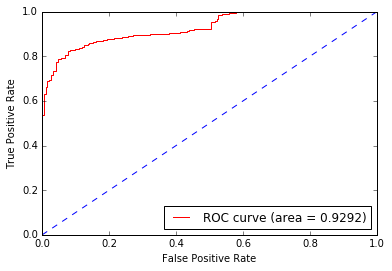

In [51]:
y2=coding(train_label,{'Y':1,'N':0})

preds = rf.predict_proba(x)[:,1]
fpr, tpr, thres = roc_curve(y2, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Run RF model on test data set

In [14]:
test=pd.read_csv('test_data.csv')
rf_test=test
print "Before imputation on test data:"
print rf_test.apply(num_missing,axis=0)

#fill in blank
from scipy.stats import mode
rf_test['Gender'].fillna(mode(data['Gender']).mode[0],inplace=True)
rf_test['Self_Employed'].fillna(mode(data['Self_Employed']).mode[0],inplace=True)
rf_test['Married'].fillna(mode(data['Married']).mode[0],inplace=True)
rf_test['Loan_Amount_Term'].fillna(mode(data['Loan_Amount_Term']).mode[0],inplace=True)
rf_test['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)
rf_test['Credit_History'].fillna(0,inplace=True)
#recode categorical variables
rf_test['Property_Area_coded']=coding(rf_train['Property_Area'],{'Urban':0,'Semiurban':1,'Rural':2})
rf_test['Gender_coded']=coding(rf_train['Gender'],{'Male':0,'Female':1})
rf_test['Married_coded']=coding(rf_train['Married'],{'Yes':0,'No':1})
rf_test['Education_coded']=coding(rf_train['Education'],{'Not Graduate':0,'Graduate':1})
rf_test['Self_Employed_coded']=coding(rf_train['Self_Employed'],{'Yes':0,'No':1})
rf_test['Dependents_coded']=coding(rf_train['Dependents'],{'0':0,'1':1,'2':2,'3+':3})


#fill in dependents
rf_test.loc[(rf_test['Dependents_coded'].isnull() ) & (rf_test['Married']=='Yes'), 'Dependents_coded']=rf_train.groupby('Married')['Dependents_coded'].mean()[1]
rf_test.loc[(rf_test['Dependents_coded'].isnull() ) & (rf_test['Married']=='No'), 'Dependents_coded']=rf_train.groupby('Married')['Dependents_coded'].mean()[0]

print "After imputation:"
print rf_test.apply(num_missing,axis=0)

x=rf_test.drop(['Loan_ID','Property_Area','Gender','Married','Education','Self_Employed','Dependents'],1)
py=rf.predict(x)


rf_test['Loan_Status']=py
print rf_test.shape
print display(rf_test.head())

submission=rf_test.loc[:,['Loan_ID','Loan_Status']]
print submission.shape
print submission.apply(num_missing,axis=0)
print display(submission.head(5))
submission.to_csv('test_result_rf_imp_0302',header=True,index = False)


Before imputation on test data:
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64
After imputation:
Loan_ID                 0
Gender                  0
Married                 0
Dependents             10
Education               0
Self_Employed           0
ApplicantIncome         0
CoapplicantIncome       0
LoanAmount              0
Loan_Amount_Term        0
Credit_History          0
Property_Area           0
Property_Area_coded     0
Gender_coded            0
Married_coded           0
Education_coded         0
Self_Employed_coded     0
Dependents_coded        0
dtype: int64
(367, 19)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Property_Area_coded,Gender_coded,Married_coded,Education_coded,Self_Employed_coded,Dependents_coded,Loan_Status
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,0,1,1,1,0.0,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,2,0,0,1,1,1.0,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,0,0,1,0,0.0,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,0.0,Urban,0,0,0,0,1,0.0,N
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,0,0,1,1,1,0.0,Y


None
(367, 2)
Loan_ID        0
Loan_Status    0
dtype: int64


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,N
4,LP001051,Y


None


Testing score using Random Forest with imputation is 0.777 which is slightly better than logistic regression 0.7638